# Cross-Validation and AUCs of LRM per cell line idea (unique drug-indication pairs)

## *1. Import the DRH and clinical trials datasets*

In [1]:
# import data manipulation tools
import pandas as pd
import numpy as np

In [2]:
### initialize dictionaries to store the DRH and clinical datasets
DRH_data = {}
clin_data = {}
### store a list of the cell lines used
cell_lines = ["A375", "MCF7", "PC3"]

### iterate through each cell line
for cell_line in cell_lines:
    ## store the DRH and clinical datasets in their respective dictionaries
    file_path = "./DRH_clin_data/DRH_data/" + cell_line + "_unique_ind.txt"
    DRH_data[cell_line] = pd.read_csv(file_path)
    
    file_path = "./DRH_clin_data/clin_data/" + cell_line + "_unique_ind.txt"
    clin_data[cell_line] = pd.read_csv(file_path)

DRH_data["MCF7"].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
0,midostaurin,0.799386,altrenogest,0.812819,0.908978,Estrus,False
1,altrenogest,0.812819,midostaurin,0.799386,0.908978,"Leukemia, Myeloid, Acute",False
2,ixazomib-citrate,0.747696,ixazomib,0.791817,0.889649,Multiple Myeloma,True
3,ixazomib,0.791817,ixazomib-citrate,0.747696,0.889649,Multiple Myeloma,True
4,carfilzomib,0.763093,ixazomib-citrate,0.747696,0.839315,Multiple Myeloma,True


## *2. Generate the shared data filtered by TAS cutoff*

In [3]:
### function to select only drug-indication pairs above TAS cutoff
def gen_tas_datasets(cell_line_data):
    ## initialize a dictionary to store all the filtered datasets at each tas cutoff
    tas_data = {}
    ## iterate through each tas cutoff
    for tas_cutoff in tas_cutoffs:
        ## store only drug-indication pairs below tas cutoff in the dictionary
        drug1_above_tas = cell_line_data["drug1 tas"] > tas_cutoff
        drug2_above_tas = cell_line_data["drug2 tas"] > tas_cutoff
        tas_data[tas_cutoff] = cell_line_data.loc[drug1_above_tas & drug2_above_tas]
        
    return tas_data

In [4]:
### function to get the intersection dataset for a cell line
def get_shared_data(DRH_data, clin_data, cell_line):
    ## get the DRH and clinical trials data for that cell line
    DRH = DRH_data[cell_line]
    clin = clin_data[cell_line]
    ## create a dataframe containing the rows in both datasets
    cols = DRH.columns.tolist()[:-1]
    shared_data = pd.merge(DRH, clin, on=cols, suffixes=("_DRH", "_clin"), how="inner")
    
    return shared_data

In [5]:
### initialize a dictionary to store all the shared data across all cell lines
shared_data = {}

### store a list of all tas cutoffs of interest
tas_cutoffs = [0, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### iterate through each cell line
for cell_line in cell_lines:
    ## get the rows present in both DRH and clinical trials
    cell_line_data = get_shared_data(DRH_data, clin_data, cell_line)
    ## generate the store the tas datasets for this shared data
    shared_data[cell_line] = gen_tas_datasets(cell_line_data)
    
shared_data["MCF7"][0.5].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind_DRH,known ind_clin
0,ixazomib,0.791817,metronidazole,0.641509,0.770292,Rosacea,False,False
1,5-aminolevulinic-acid,0.618329,sitagliptin,0.587846,0.750782,Diabetes Mellitus,False,False
2,sitagliptin,0.587846,5-aminolevulinic-acid,0.618329,0.750782,Glioma,False,False
3,sitagliptin,0.587846,5-aminolevulinic-acid,0.618329,0.750782,"Keratosis, Actinic",False,False
4,macitentan,0.561786,phenylbutyrate,0.508335,0.741032,"Urea Cycle Disorders, Inborn",False,False


## *3. Generate the training and testing datasets* 

In [6]:
### function to split the neithers while maintaining same percentage of 0s for tas cutoff
def split_neithers(shared_data):
    ## store whether the drug-indication pairs are in DRH and clinical trials independently
    in_DRH = shared_data["known ind_DRH"]
    in_clin = shared_data["known ind_clin"]
    ## get the drug-indications that are only in clinical trials
    only_in_clin = shared_data.loc[~in_DRH & in_clin]
    ## get the dataframe containing the other drug-indications
    DRH = shared_data.drop(only_in_clin.index)
    ## get the drug-indications that are not in either DRH or clinical trials
    neither_data = shared_data.loc[~in_DRH & ~in_clin]
    
    ## get the relevant information about the datasets
    DRH_true = DRH["known ind_DRH"].sum()
    clin_true = only_in_clin["known ind_clin"].sum()
    total_neithers = len(neither_data)
    ## calculate the number of neithers to add to clinical trials
    num2add = (clin_true*total_neithers)/(DRH_true + clin_true)
    clin_neither = neither_data.sample(n=num2add, random_state=42)
    
    return only_in_clin, DRH, clin_neither

In [7]:
### function to generate training dataset for one cell line
def gen_train_test_data(shared_data, cell_line):
    ## initialize dictionaries to store the training and testing datasets
    train = {}
    test = {}
    
    ## iterate through each tas cutoff
    for tas_cutoff in tas_cutoffs:
        ## store the dataset for that cell line and tas cutoff
        shared_tas = shared_data[cell_line][tas_cutoff]
        ## randomly split the neithers while maintaing percent trues
        only_in_clin, DRH, clin_neither = split_neithers(shared_tas)
        ## generate the training datasets
        train_tas = DRH.drop(clin_neither.index)
        train_tas = train_tas.drop(["known ind_clin"], axis=1)
        train_tas.rename(columns={"known ind_DRH": "known ind"}, inplace=True)
        ## store the training dataset in the dictionary for all tas cutoffs
        train[tas_cutoff] = train_tas

        ## generate the testing dataset
        test_tas = pd.concat([only_in_clin, clin_neither])
        test_tas = test_tas.drop(["known ind_DRH"], axis=1)
        test_tas.rename(columns={"known ind_clin": "known ind"}, inplace=True)
        ## generate the separate datasets for each TAS cutoff
        test[tas_cutoff] = test_tas
    
    return train, test

In [8]:
### initialize a dictionary to store the training datasets for each cell line
train_data = {}
test_data = {}

### iterate through each cell line
for cell_line in cell_lines:
    ## generate and store all the tas datasets for that cell line
    train, test = gen_train_test_data(shared_data, cell_line)
    train_data[cell_line] = train
    test_data[cell_line] = test
    
train_data["MCF7"][0.5].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
1,5-aminolevulinic-acid,0.618329,sitagliptin,0.587846,0.750782,Diabetes Mellitus,False
12,valrubicin,0.794730,doxorubicin,0.732233,0.725946,Urinary Bladder Neoplasms,True
14,doxorubicin,0.732233,valrubicin,0.794730,0.725946,Urinary Bladder Neoplasms,True
19,lurasidone,0.566841,palbociclib,0.575843,0.712300,Breast Neoplasms,False
31,mebendazole,0.684513,podophyllotoxin,0.704934,0.699762,Condylomata Acuminata,False


In [9]:
test_data["MCF7"][0.5].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
5,metronidazole,0.641509,sitagliptin,0.587846,0.727970,Diabetes Mellitus,True
33,belinostat,0.672252,romidepsin,0.795148,0.692400,"Lymphoma, T-Cell, Cutaneous",True
34,romidepsin,0.795148,belinostat,0.672252,0.692400,"Lymphoma, T-Cell, Peripheral",True
49,mepacrine,0.806568,crizotinib,0.670493,0.676249,"Carcinoma, Non-Small-Cell Lung",True
144,amsacrine,0.660436,mitoxantrone,0.681046,0.610274,"Leukemia, Myeloid, Acute",True


## *4. Evaluate Model*

### a. Cross-Validation

In [10]:
# import the data modeling and evaluation tools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, precision_score, recall_score, f1_score

In [11]:
# initialize the parameters of the logistic regression model
lrm = LogisticRegression(class_weight="balanced", solver="lbfgs", random_state=42)

# intialize the parameters of the Stratified KFold
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# create a dictionary to define the evaluation metrics of interest
metrics = {"AUC": make_scorer(roc_auc_score),
           "precision": make_scorer(precision_score),
           "recall": make_scorer(recall_score),
           "F1 score": make_scorer(f1_score)}

In [12]:
### function to perform cross-validation for one cell line
def gen_cv_scores(train_data, cell_line):
    ## initialize dataframe to store the evaluation metrics for training and validations datasets
    cv_scores = pd.DataFrame()
    ## iterate through the tas cutoffs
    for tas_cutoff in tas_cutoffs:
        # store the tas dataset
        tas_data = train_data[cell_line][tas_cutoff]
        # define the inputs and outputs to train the model
        train_cols = ["spearman corr"]
        X, y = tas_data[train_cols], tas_data["known ind"]
        # perform stratified kfold cross-validation on training and validation datasets
        tas_cv = cross_validate(lrm, X, y, cv=skf, scoring=metrics, return_train_score=True)
        # add the results to the dataframe
        tas_scores = pd.DataFrame(tas_cv).drop(["fit_time", "score_time"], axis=1)
        cv_scores = cv_scores.append(tas_scores.mean(), ignore_index=True)
    ## add the tas cutoffs
    cv_scores.insert(0, "TAS cutoff", tas_cutoffs)
    
    ## rename columns
    cv_scores = cv_scores.rename(columns={
    "test_AUC": "val_AUC",
    "test_F1 score": "val_F1 score",
    "test_precision": "val_precision",
    "test_recall": "val_recall"})
    ## reorder columns
    cols = ["TAS cutoff", "train_AUC", "train_F1 score", "train_precision", "train_recall", 
            "val_AUC", "val_F1 score", "val_precision", "val_recall"]
    cv_scores = cv_scores[cols]
    
    return cv_scores

In [13]:
### redefine the tas cutoffs
tas_cutoffs = [0, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### initialize a dictionary to store results from cross-validation for all cell lines
cv_scores = {}

### iterate through each cell line
for cell_line in cell_lines:
    ## generate and store results from cross-validation for that cell line in dictionary
    cv_scores[cell_line] = gen_cv_scores(train_data, cell_line)
cv_scores["MCF7"]

,TAS cutoff,train_AUC,train_F1 score,train_precision,train_recall,val_AUC,val_F1 score,val_precision,val_recall
0,0.00,0.615249,0.094405,0.051072,0.623329,0.616155,0.094663,0.051227,0.622742
1,0.20,0.625780,0.116637,0.063945,0.663082,0.627616,0.117479,0.064395,0.673611
2,0.25,0.657541,0.143552,0.080150,0.694444,0.661763,0.144099,0.080635,0.690476
3,0.30,0.785755,0.276081,0.164581,0.859259,0.789437,0.276741,0.165221,0.866667
4,0.35,0.798413,0.340721,0.209626,0.910714,0.801423,0.349206,0.216399,0.916667
5,0.40,0.863636,0.426002,0.271193,1.000000,0.853535,0.417647,0.265873,1.000000
6,0.45,0.844309,0.456443,0.295895,1.000000,0.845635,0.480556,0.326923,1.000000
7,0.50,0.868708,0.487179,0.322222,1.000000,0.861722,0.490476,0.327778,1.000000


### b. Cross-Validation ROC Curves

In [14]:
# import data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# set theme of figures
sns.set_style("whitegrid")

# set the font sizes of plots
plt.rcParams["axes.titlesize"] = 17 # title 
plt.rcParams["axes.labelsize"] = 15 # X and y axis labels
plt.rcParams["xtick.labelsize"] = 15  # X tick labels
plt.rcParams["ytick.labelsize"] = 15  # Y tick labels
plt.rcParams["legend.fontsize"] = 15 # legend

In [16]:
### function to compare training to validation scores across all cell lines and tas cutoff
def compare_metric(metric_scores, metric1, metric2, metric):
    ## create a dataframe with the metric
    scores = pd.DataFrame()
    scores["TAS cutoff"] = tas_cutoffs
    
    ## initialize a figure
    #plt.style.use("seaborn-whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    ## iterate through each cell line
    for model in metric_scores.keys():
        # store the data for that cell line
        model_scores = metric_scores[model]
        # create a line plot showing the results on training datasets
        ax[0].plot(model_scores["TAS cutoff"], model_scores[metric1], marker="o", label=model)
        # create a line plot showing the results on validation datasets
        ax[1].plot(model_scores["TAS cutoff"], model_scores[metric2], marker="o", label=model)
        
        # add the data to the dataframe
        scores[model + "_" + metric1] = model_scores[metric1]
        scores[model + "_" + metric2] = model_scores[metric2]
        
    ## add titles to each plot
    ax[0].set_title("ROC Curves of Individual Cell Line Models \non Training Datasets")
    ax[1].set_title("ROC Curves of Individual Cell Line Models \non Validation Datasets")
    
    ## add labels and axis limits to each plot
    for i in range(2):
        ax[i].set_xlabel("TAS cutoff")
        ax[i].set_ylabel(metric)
        ax[i].set_ylim(0.4, 1)
        ax[i].legend()
        
    # show plot
    plt.show()
    
    return scores

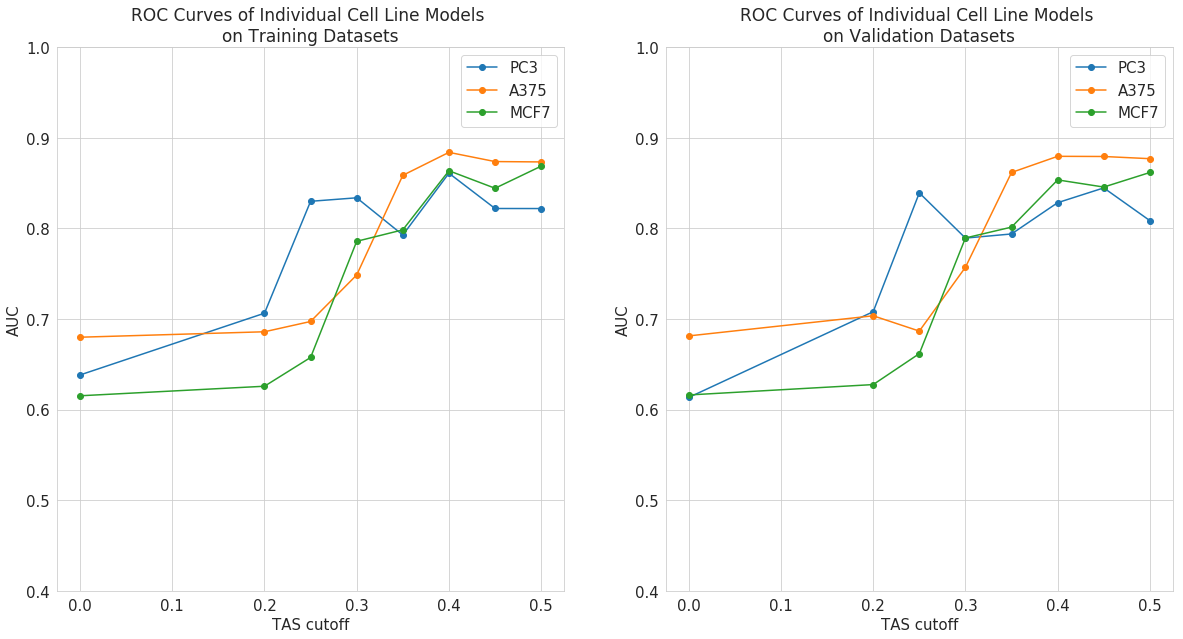

,TAS cutoff,PC3_train_AUC,PC3_val_AUC,A375_train_AUC,A375_val_AUC,MCF7_train_AUC,MCF7_val_AUC
0,0.00,0.638228,0.613410,0.679892,0.681330,0.615249,0.616155
1,0.20,0.706388,0.708054,0.685906,0.703547,0.625780,0.627616
2,0.25,0.829911,0.839214,0.697265,0.686654,0.657541,0.661763
3,0.30,0.833776,0.789295,0.748609,0.757091,0.785755,0.789437
4,0.35,0.792710,0.793863,0.858586,0.861746,0.798413,0.801423
5,0.40,0.860905,0.828395,0.883934,0.879564,0.863636,0.853535
6,0.45,0.821970,0.844697,0.873760,0.879368,0.844309,0.845635
7,0.50,0.821911,0.808559,0.873370,0.876944,0.868708,0.861722


In [17]:
# compare cross-validation average AUCs in training and validation datasets across all folds
compare_metric(cv_scores, "train_AUC", "val_AUC", "AUC")

### c. Generate predictions on Clinical Trials on model trained on with and without TAS

In [18]:
### function to generate predictions on training and testing datasets for one cell line
def gen_pred(train_data, test_data, cols, cell_line):
    ## initialize dictionaries to store the predictions
    train_pred = {}
    test_pred = {}
    ## iterate through all the tas cutoffs
    for tas_cutoff in tas_cutoffs:
        # store the training and testing datasets at that tas cutoff
        train_tas = train_data[cell_line][tas_cutoff]
        test_tas = test_data[cell_line][tas_cutoff]
        
        # train the model on all the training data
        X_train, y_train = train_tas[cols], train_tas["known ind"]
        lrm.fit(X_train, y_train)
        # add the predicted probabilities to the training dataset
        train_tas["predicted prob"] = lrm.predict_proba(X_train)[:, 1]
        # add the predicted probabilities to the testing dataset
        X_test = test_tas[cols]
        test_tas["predicted prob"] = lrm.predict_proba(X_test)[:, 1]
        
        # store the predictions in their respective dictionaries
        train_pred[tas_cutoff] = train_tas
        test_pred[tas_cutoff] = test_tas
        
    return train_pred, test_pred

In [19]:
### initialize dictionaries to store training and testing datasets with predictions
train_pred = {}
test_pred = {}

### iterate through each cell line
for cell_line in cell_lines:
    ## generate the predictions for that cell line
    cols = ["spearman corr"]
    train_tas, test_tas = gen_pred(train_data, test_data, cols, cell_line)
    ## store the datasets to their respective dictionaries
    train_pred[cell_line] = train_tas
    test_pred[cell_line] = test_tas

train_pred["MCF7"][0.3].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind,predicted prob
4,macitentan,0.561786,phenylbutyrate,0.508335,0.741032,"Urea Cycle Disorders, Inborn",False,0.759802
12,valrubicin,0.794730,doxorubicin,0.732233,0.725946,Urinary Bladder Neoplasms,True,0.746831
14,doxorubicin,0.732233,valrubicin,0.794730,0.725946,Urinary Bladder Neoplasms,True,0.746831
16,valrubicin,0.794730,doxorubicin,0.732233,0.725946,Precursor Cell Lymphoblastic Leukemia-Lymphoma,False,0.746831
19,lurasidone,0.566841,palbociclib,0.575843,0.712300,Breast Neoplasms,False,0.734706


In [20]:
### function to determine the cell line weights
def gen_weights(train_pred, tas_cutoff):
    ## store the predictions for each cell line
    cols = ["drug1", "indication", "predicted prob", "known ind"]
    A375 = train_pred["A375"][tas_cutoff][cols]
    MCF7 = train_pred["MCF7"][tas_cutoff][cols]
    PC3 = train_pred["PC3"][tas_cutoff][cols]
        
    ## 1. generate the intersection dataset across all cell lines
    shared_data = pd.merge(A375, MCF7, on=["drug1", "indication"], how="inner", suffixes=("_A375", "_MCF7"))
    shared_data = pd.merge(shared_data, PC3, on=["drug1", "indication"], how="inner")
    shared_data.rename(columns={"predicted prob": "predicted prob_PC3"}, inplace=True)
    ##
        
    ## 2. calculate the cell line weights using another LRM trained on their predictions
    # define the inputs and outputs to the LRM
    X, y = shared_data.drop(columns=["drug1", "indication", "known ind"], axis=1), shared_data["known ind"].astype(int)
    # train the LRM of this data
    lrm.fit(X, y)
    # create a dictionary to store the weights
    tas_weights = {"MCF7": lrm.coef_[0][0],
                   "A375": lrm.coef_[0][1],
                   "PC3": lrm.coef_[0][2]}
    ##
    
    ## 3. generate the weighted average dataset (union across all cell lines)
    weighted_train = pd.merge(A375, MCF7, on=["drug1", "indication"], how="outer", suffixes=("_A375", "_MCF7"))
    weighted_train = pd.merge(weighted_train, PC3, on=["drug1", "indication"], how="outer")
    weighted_train.rename(columns={"predicted prob": "predicted prob_PC3",
                                   "known ind": "known ind_PC3"}, inplace=True)
    # combine the labelled outputs across all cell lines into one column
    cols = ["known ind_A375", "known ind_MCF7", "known ind_PC3"]
    weighted_train["known ind"] = weighted_train[cols].any(axis=1)
    weighted_train.drop(cols, axis=1, inplace=True)
    weighted_train.rename(columns={"predicted prob_A375": "A375",
                                   "predicted prob_MCF7": "MCF7",
                                   "predicted prob_PC3": "PC3",}, inplace=True)
    ##
        
    return weighted_train, tas_weights

In [21]:
### function to calculate the weighted average probability for one row
def weighted_avg(row, tas_weights):
    ## initialize variables to store the weighted sum and total weight
    total_weight = 0
    weighted_sum = 0
    ## iterate through each weight
    for col, weight in tas_weights.items():
        # if drug-indication is in cell line dataset
        if not pd.isnull(row[col]):
            # add the weights and values to their respectives variables
            weighted_sum += row[col] * weight
            total_weight += weight
    
    ## calculate the weighted probability
    return weighted_sum / total_weight

In [22]:
### function to generate the predictions for the weighted average model
def gen_weighted_avg(train_pred, test_pred):
    ## intialize dictionaries to store the data for the weighted average models
    weighted_train = {}
    weighted_test = {}
    cell_line_weights = {}
    
    ## iterate through each tas cutoff
    for tas_cutoff in tas_cutoffs:
        ## 1. get the weighted average predictions across the training datasets
        # generate the weights for that tas cutoff
        tas_weighted_train, tas_weights = gen_weights(train_pred, tas_cutoff)
        # add the weighted probabilities
        tas_weighted_train["predicted prob"] = tas_weighted_train.apply(weighted_avg, axis=1, tas_weights=tas_weights)
        # store the data in the dictionary
        weighted_train[tas_cutoff] = tas_weighted_train
        cell_line_weights[tas_cutoff] = tas_weights
        ##


        ## 2. get the weighted average predictions across the testing datasets
        # store the predictions for each cell line in the testing dataset
        cols = ["drug1", "indication", "predicted prob", "known ind"]
        A375 = test_pred["A375"][tas_cutoff][cols]
        MCF7 = test_pred["MCF7"][tas_cutoff][cols]
        PC3 = test_pred["PC3"][tas_cutoff][cols]
        # generate the weighted average dataset (union across all cell lines)
        tas_weighted_test = pd.merge(A375, MCF7, on=["drug1", "indication"], how="outer", suffixes=("_A375", "_MCF7"))
        tas_weighted_test = pd.merge(tas_weighted_test, PC3, on=["drug1", "indication"], how="outer")
        tas_weighted_test.rename(columns={"predicted prob": "predicted prob_PC3",
                                       "known ind": "known ind_PC3"}, inplace=True)
        # combine the labelled outputs across all cell lines into one column
        cols = ["known ind_A375", "known ind_MCF7", "known ind_PC3"]
        tas_weighted_test["known ind"] = tas_weighted_test[cols].any(axis=1)
        tas_weighted_test.drop(cols, axis=1, inplace=True)
        tas_weighted_test.rename(columns={"predicted prob_A375": "A375",
                                       "predicted prob_MCF7": "MCF7",
                                       "predicted prob_PC3": "PC3",}, inplace=True)
        # add the weighted probabilities
        tas_weighted_test["predicted prob"] = tas_weighted_test.apply(weighted_avg, axis=1, tas_weights=tas_weights)
        # store the data in the dictionary
        weighted_test[tas_cutoff] = tas_weighted_test
        ##
    
    return weighted_train, weighted_test, cell_line_weights

In [23]:
## redefine tas cutoffs
tas_cutoffs = [0, 0.2, 0.25]

# calculate and store the weighted probabilities for training and testing datasets
train_pred["weighted avg"], test_pred["weighted avg"], cell_line_weights = gen_weighted_avg(train_pred, test_pred)
train_pred["weighted avg"][0.2].head()

,drug1,indication,A375,MCF7,PC3,known ind,predicted prob
0,pitavastatin,Myocardial Infarction,0.896607,NaN,NaN,False,0.896607
1,clofarabine,"Leukemia, Hairy Cell",0.886319,NaN,NaN,False,0.886319
2,clofarabine,Pancreatic Neoplasms,0.882300,NaN,NaN,False,0.882300
3,rebamipide,Attention Deficit Disorder with Hyperactivity,0.875802,NaN,NaN,False,0.875802
4,atomoxetine,Gastritis,0.875802,NaN,NaN,False,0.875802


In [24]:
cell_line_weights[0.2]

{'A375': 1.2854715050256023,
 'MCF7': 0.38506050766427624,
 'PC3': 0.09197353144750729}

In [25]:
### function to generate AUCs for training and testing datasets for one cell line
def gen_train_test_scores(train_pred, test_pred, model):
    ## store all predictions into one dictionary
    pred = {"train": train_pred,
            "test": test_pred}
    
    ## initialize a dataframe to store the AUCs
    train_test_scores = pd.DataFrame()
    ## iterate through each tas cutoff
    for tas_cutoff in tas_cutoffs:
        ## initialize a dictionary to store the evaluation metric scores at tas cutoff
        tas_aucs = {}
        tas_aucs["TAS cutoff"] = tas_cutoff
        ## iterate through each dataset
        for dataset in pred:
            # get the model predictions and actual labels
            tas_data = pred[dataset][model][tas_cutoff]
            tas_pred = tas_data["predicted prob"]
            tas_actual = tas_data["known ind"]
            tas_pred_classes = (tas_pred > 0.5).astype(int)
            
            # store the evaluation metric scores
            tas_aucs[dataset + "_AUC"] = roc_auc_score(tas_actual, tas_pred)
            tas_aucs[dataset + "_F1 score"] = f1_score(tas_actual, tas_pred_classes)
            tas_aucs[dataset + "_precision"] = precision_score(tas_actual, tas_pred_classes)
            tas_aucs[dataset + "_recall"] = recall_score(tas_actual, tas_pred_classes)
            
        ## add the aucs at that tas cutoff to the dataframe
        train_test_scores = train_test_scores.append(tas_aucs, ignore_index=True)
        
    return train_test_scores

In [26]:
### initialize a dictionary to store all of the evaluation metrics for all cell lines
train_test_scores = {}

### iterate through each cell line
for model in train_pred.keys():
    ## generate and store the evaluation metric scores for cell line in dictionary
    train_test_scores[model] = gen_train_test_scores(train_pred, test_pred, model)
train_test_scores["MCF7"]

,TAS cutoff,test_AUC,test_F1 score,test_precision,test_recall,train_AUC,train_F1 score,train_precision,train_recall
0,0.00,0.711766,0.101834,0.054919,0.698675,0.664884,0.094306,0.051011,0.623529
1,0.20,0.675630,0.116583,0.063596,0.698795,0.685574,0.117202,0.064182,0.673913
2,0.25,0.688780,0.138389,0.076761,0.701923,0.741159,0.142222,0.079208,0.695652


In [27]:
test_pred["weighted avg"][0].head()

,drug1,indication,A375,MCF7,PC3,known ind,predicted prob
0,atorvastatin,Hyperlipidemias,0.928433,0.786987,0.868162,True,0.899704
1,cladribine,Precursor Cell Lymphoblastic Leukemia-Lymphoma,0.920844,NaN,0.724302,True,0.905612
2,gemcitabine,Precursor Cell Lymphoblastic Leukemia-Lymphoma,0.917859,0.738818,0.728660,True,0.874283
3,belinostat,"Lymphoma, T-Cell, Cutaneous",0.900137,0.806237,0.857158,True,0.880876
4,vorinostat,"Lymphoma, T-Cell, Peripheral",0.900137,NaN,0.857158,True,0.896806


### d. Save predictions for future access

In [28]:
### create a dataframe
all_pred = pd.DataFrame()
### iterate through predictions for each cell line
for cell_line in cell_lines:
    ## add cell line predictions to dataframe
    all_pred = pd.concat([all_pred, test_pred[cell_line][0]])
### remove unnecessary columns
all_pred.drop(columns=["drug1 tas", "drug2 tas", "known ind", "predicted prob"], axis=1, inplace=True)
### sort data from highest to lowest spearman correlation
all_pred.sort_values("spearman corr", ascending=False, inplace=True)
### keep only the highest correlated drug 2 for each drug-indication
all_pred.drop_duplicates(subset=["drug1", "indication"], keep="first", inplace=True)
### rename columns
all_pred.rename({"drug2": "most correlated drug"}, axis=1, inplace=True)
all_pred.head()

,drug1,most correlated drug,spearman corr,indication
0,metronidazole,lacidipine,0.928048,Hypertension
4,atorvastatin,pitavastatin,0.860484,Hyperlipidemias
3,pitavastatin,atorvastatin,0.860484,Myocardial Infarction
2,pitavastatin,atorvastatin,0.860484,Stroke
5,cladribine,clofarabine,0.836042,Precursor Cell Lymphoblastic Leukemia-Lymphoma


In [29]:
# create a new dataframe containing the weighted average ensemble model's predictions
cols = ["drug1", "indication", "known ind", "predicted prob"]
model_pred = test_pred["weighted avg"][0][cols]
# add information about the most correlated drug
model_pred = pd.merge(model_pred, all_pred, on=["drug1", "indication"], how="left")
# rename column
model_pred.rename({"drug1": "drug"}, axis=1, inplace=True)
# model_pred.to_csv("model_pred.txt", sep="\t", index=False)

### e. ROC Curves of Models on Clinical Trials

In [30]:
### function to generate the weighted ensemble model trained only on spearman correlation
def gen_tas_model(tas_cutoffs):
    ### 1. generate the cell line model predictions
    train_pred = {}
    test_pred = {}
    ## iterate through each cell line
    for cell_line in cell_lines:
        # generate the predictions for that cell line
        cols = ["drug1 tas", "drug2 tas", "spearman corr"]
        train_tas, test_tas = gen_pred(train_data, test_data, cols, cell_line)
        # store the datasets to their respective dictionaries
        train_pred[cell_line] = train_tas
        test_pred[cell_line] = test_tas
    ###
        
    ### 2. calculate and store the weighted probabilities for training and testing datasets
    train_pred["weighted avg"], test_pred["weighted avg"], cell_line_weights = gen_weighted_avg(train_pred, test_pred)
    ###
    
    return train_pred, test_pred, cell_line_weights

In [31]:
# generate the models trained only spearman correlation
train_tas, test_tas, tas_weights = gen_tas_model(tas_cutoffs)
train_pred["weighted avg w/ TAS"] = train_tas["weighted avg"]
test_pred["weighted avg w/ TAS"] = test_tas["weighted avg"]
tas_weights

{0: {'A375': 2.3050960060655266,
  'MCF7': 0.5342571428875991,
  'PC3': 0.16752145108912309},
 0.2: {'A375': 1.2679337404141477,
  'MCF7': 0.3805524433422714,
  'PC3': 0.1799294882196162},
 0.25: {'A375': 0.7885868453276291,
  'MCF7': 0.31556450629191574,
  'PC3': 0.31472110947314735}}

In [32]:
### function to generate ROC curve with AUCs for all model at TAS > 0.2
def gen_intersection_rocs(tas_cutoff, ax):
    ## store the intersection of the testing datasets at that tas cutoff
    test = test_pred["weighted avg"][tas_cutoff]
    test = test.rename({"predicted prob": "weighted avg"}, axis=1)
    test.dropna(inplace=True)
    ## store a list with all models of interest
    models = ["A375", "MCF7", "PC3", "weighted avg"]
    ## iterate through the data for each model
    for model in models:
        # generate the ROC curve
        y_actual = test["known ind"]
        y_pred = test[model]
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        auc = roc_auc_score(y_actual, y_pred)
        ax.plot(fpr, tpr, label = model + " (AUC = " + str(round(auc, 3)) + ")")
    
    ## add labels and legend
    ax.set_title("ROC Curves on Clinical Trials Across Shared Drug Indications")
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [33]:
### function to generate ROC curve with AUCs for all models
def compare_tas(tas_cutoff, ax):
    ## store a list with all models of interest
    models = ["weighted avg", "weighted avg w/ TAS"]
    ## iterate through the predicted probabilties for each model
    for model in models:
        ## store the intersection of the testing datasets at that tas cutoff
        test = test_pred[model][tas_cutoff]
        # generate the ROC curve
        y_actual = test["known ind"]
        y_pred = test["predicted prob"]
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        auc = roc_auc_score(y_actual, y_pred)
        plt.plot(fpr, tpr, label = model + " (AUC = " + str(round(auc, 3)) + ")")
    
    ## add labels and legend
    ax.set_title("ROC Curves on Clinical Trials")
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

In [34]:
### function to generate figure comparing AUCs on Clinical Trials
def compare_aucs(tas_cutoff):
    ## create an empty figure to place 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    ## generate the left plot comparing the ROC curves on shared drug indication of clinical trials
    gen_intersection_rocs(tas_cutoff, ax1)
    ## generate the right plot comparing the ROC curves of model with and without TAS
    compare_tas(tas_cutoff, ax2)
    
    ## show figure
    plt.show()

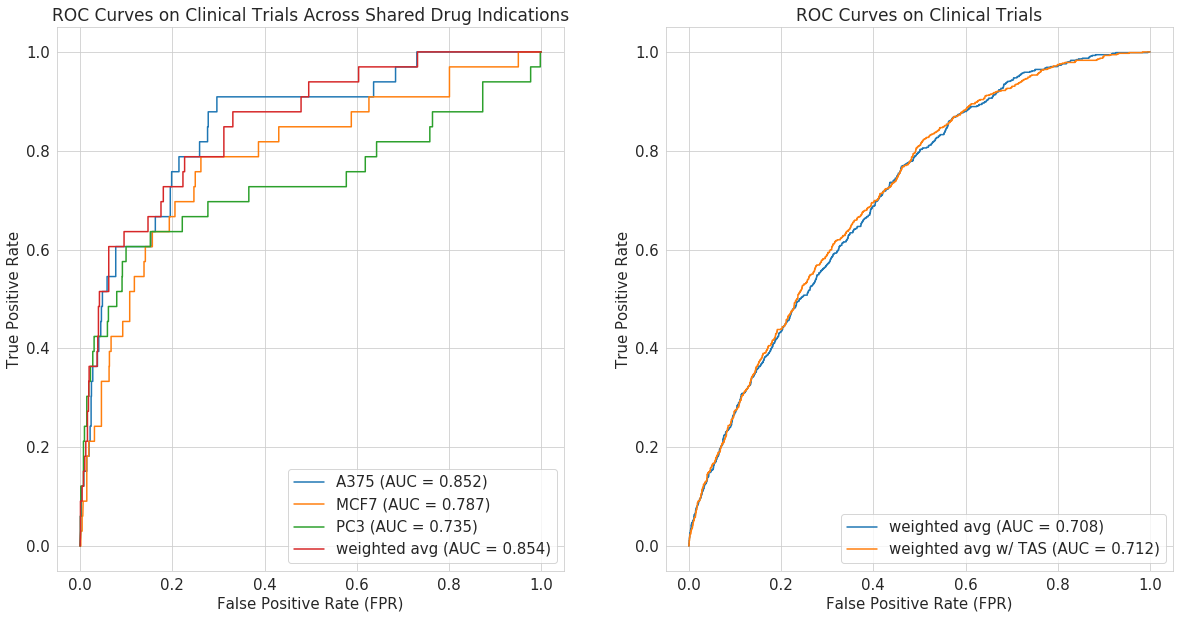

In [35]:
compare_aucs(0)

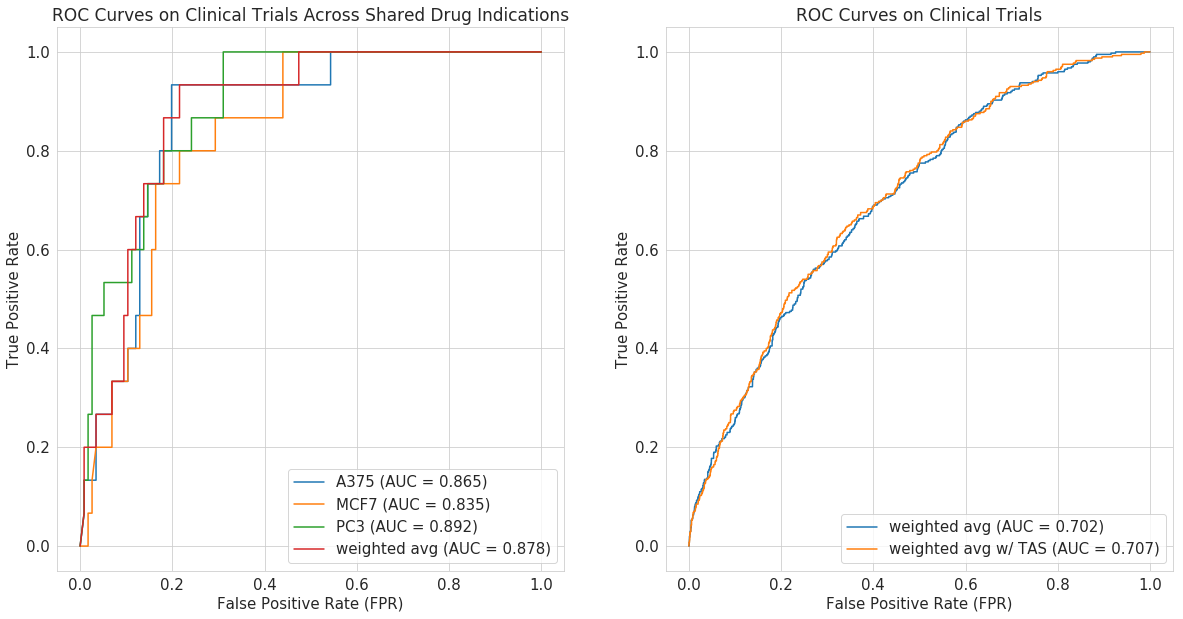

In [36]:
compare_aucs(0.2)